## Hand-written Digit Classification using feature-based linear regression  
EECS 551, F21  <br>
2018-10-02 Jeff Fessler and Steven Whitaker <br>
2019-10-04 modified by Caroline Crockett <br>
2020-09-30 switch to including the sign of y in A <br>
2021-10-05 modified by Eric Cheek

## Group Formation and General Instructions
You may work individually, but we recommend that you work in pairs or groups of three. Find someone to work with and introduce yourself to them! One of you should copy the Google Document template and share the document with edit permissions with your group member(s): 
https://docs.google.com/document/d/1Y6ClEUk6u8LRXyQP-8BtheV3bzKT_r-iJp00QEsKemw/template/preview (you must use your umich email address to access this google document). 

The Google Document will include your answers to a couple of questions that will be asked. For each question, pick someone to type up your **group's** response. After completing the response, the group member should sign their name by typing it below the answer. For the next question, have a different group member respond and sign their name in the same way. Keep rotating until all the questions have been answered.

The goal of this group exercise is to formulate your response as a group to the problem. At the end of discussion, **one** student in the group must submit a PDF of the google document to gradescope, entering the uniquenames of **all** students in the group. One group submits exactly one PDF, but we expect the PDF from different groups to differ. The deadline for submitting to gradescope will be announced on Canvas. Only submit the filled-in google document; do not submit a download of this Jupyter notebook. 

### Overview
This task illustrates how to classify handwritten digits
using linear regression based on "hand crafted" features.
We focus on just the two digits "0" and "1" although the principles generalize to all digits.

In [3]:
# packages needed
using Plots
using Statistics: mean
using MIRTjim: jim
using LinearAlgebra

### Part 0: load the data and look at it
You do not need to do any coding or turn in any response for this part, you just need to run the code provided. 

In [2]:
import Pkg; Pkg.add("MLDatasets")

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [36]:
# Packages
using MLDatasets # you may need to add this package!

# read the MNIST data file for handwritten digits 0 and 1
# This code will automatically download the data from web if needed
# and put it in a folder like: ~/.julia/datadeps/MNIST/
if !@isdefined(data)
	digitn = [0, 1]
	tmpx, tmpy = MNIST.traindata(Float32)
	data = n -> tmpx[:,:,findall(tmpy .== n)[1:1000]] # 1st 1000 of digit n
	data = 255 * cat(dims=4, data.(digitn)...)
	nx, ny, nrep, ndigit = size(data)
	data = data[:,2:ny,:,:] # make images non-square to force debug
	ny = size(data,2)
	@show size(data)
end

d0 = data[:,:,:,1]
d1 = data[:,:,:,2]

display(size(d0))

(28, 27, 1000)

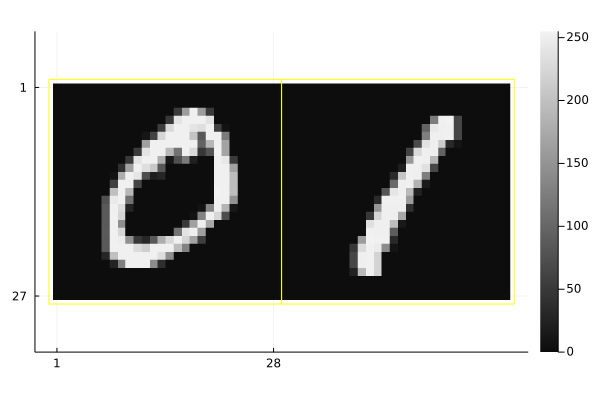

In [5]:
jim(cat(d0[:,:,1], d1[:,:,1], dims = 3))

In [37]:
# Use some data for training, and some for testing
ntrain = 100
ntest = nrep - ntrain
train0 = d0[:,:,1:ntrain] # Training data
train1 = d1[:,:,1:ntrain]
test0 = d0[:,:,(ntrain+1):end] # Testing data
test1 = d1[:,:,(ntrain+1):end];

In [35]:
# Look at mean image from each class and a couple of the images just to get a sense of things
# You do not need to include this picture in your report

mean0 = mean(train0, dims = 3)
mean1 = mean(train1, dims = 3)

# Look at a couple of the images
# jim stands for "jiffy image" and is part of the MIRT package
jim(cat(mean0, mean1, dims = 3))
display(mean0)

28×27×1 Array{Float32, 3}:
[:, :, 1] =
 0.0  0.0  0.0    0.0     0.0     0.0   …    0.0    0.0   0.0  0.0  0.0
 0.0  0.0  0.0    0.0     0.0     0.0        0.0    0.0   0.0  0.0  0.0
 0.0  0.0  0.0    0.0     0.0     0.0        0.0    0.0   0.0  0.0  0.0
 0.0  0.0  0.0    0.0     0.0     0.0        0.0    0.0   0.0  0.0  0.0
 0.0  0.0  0.0    0.0     0.0     0.0        2.65   0.0   0.0  0.0  0.0
 0.0  0.0  0.0    0.0     0.0     0.0   …   16.33   0.0   0.0  0.0  0.0
 0.0  0.0  0.0    0.0     0.0     0.82      31.59   0.8   0.0  0.0  0.0
 0.0  0.0  0.0    0.0     1.23    4.56      50.87   5.07  0.0  0.0  0.0
 0.0  0.0  0.0    0.26    4.55   12.77      77.38   5.38  0.0  0.0  0.0
 0.0  0.0  0.0    2.69   12.57   33.3      108.3    9.01  0.0  0.0  0.0
 0.0  0.0  0.0    7.16   28.45   55.26  …  130.51  14.64  0.0  0.0  0.0
 0.0  0.0  0.56  16.74   48.97   70.49     144.42  26.24  0.0  0.0  0.0
 0.0  0.0  2.47  32.36   68.42   97.54     140.89  32.73  0.0  0.0  0.0
 ⋮                       

### Part 1

The first part is to write a function that extracts features from digit images so that you can then use those features for classification.  Here you are going to use two "hand-crafted" features: the mean of the image, and the mean of the middle column of the image. In addition to these two features, for classification by linear regression we usually include a bias term (the constant ```1```).  So we have a total of 3 features.  

Write a function named ```data_to_features``` that takes as input a stack of images, i.e., a data array of size ```[nx,ny,n]```, where ```n``` is the number of images in the stack, and returns the features for each image in the stack.  The output has size ```[n,3]``` where the first column is the mean of each image, the 2nd column is the middle-column-mean of each image, and the third column is the ```1``` feature. 

Julia hints: <br> 
- If ```d``` denotes a $N_x \times N_y$ image, then ```d[Nx/2,:]``` is the middle column. Note that this is the middle row of the data matrix, but the middle column of the image because of the (hidden) transpose in the our covention for image storage and in the ```jim``` display function. <br> 
- Use the ```mean``` function to compute the mean. <br>
- Try ```Nx=10``` and ```typeof(Nx)``` and ```Nx/2``` and ```typeof(Nx/2)```. <br>  

Include the code for your  ```data_to_features``` function in your write-up. 

In [58]:
display(size(train0))
nx, ny, n = size(data)
a = mean(train0[:,:,1])
b = mean(train0, dims=(1,2))
display(a)
display(b)
Nx=10/2
typeof(Nx)
index_x = convert(Int64, nx/2)
c = mean(train0[index_x,:,1])

(28, 27, 100)

41.13095f0

1×1×100 Array{Float32, 3}:
[:, :, 1] =
 41.13095

[:, :, 2] =
 46.86905

[:, :, 3] =
 48.289684

...

[:, :, 98] =
 31.96693

[:, :, 99] =
 34.015873

[:, :, 100] =
 46.29365

65.703705f0

In [76]:
# TODO - you must write this function! 

"""
features = data_to_features(d3) 

Extracts three hand-crafted features from the given data. 

In: 
    d3 : a stack of images, i.e., a data array of size [nx,ny,n], 
            where n is the number of images in the stack

Out: 
- An array of size [n,3], where the first column is the mean of each image, 
        the 2nd column is the middle-column-mean of each image, 
        and the third column is the ```1``` feature
""" 
function data_to_features(data) # data is [nx,ny,n]
    nx, ny, n = size(data)
    features = zeros(n, 3)
    for i in 1:n
        #First col
        features[i,1] = mean(data[:,:,i])
        #Second col 
        index_x = convert(Int64, nx/2) 
        features[i,2] = mean(data[index_x,:,i])
        #Third Col
        features[i,3] = 1
        
    end
    return features # should be [n,3]

end

data_to_features

The next code block extracts the features from the training images and shows them as a scatter plot.  
Think about these questions for yourself (you do not need to answer them in your write-up):  
- Does it look like the two classes of digits are well separated? 
- If you drew a line "between" the classes, roughly what classification accuracy would you expect to get? 
- Which digit tends to have a larger mean? What about a larger middle column mean? 

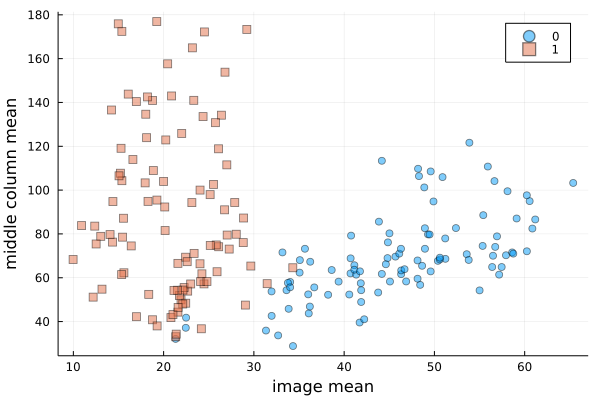

In [77]:
# scatter plot of two features, colored with digit labels

A0 = data_to_features(train0)
A1 = data_to_features(train1)


ps = scatter(A0[:,1], A0[:,2], marker=:circle, label="0", alpha=0.5)
scatter!(ps, A1[:,1], A1[:,2], marker=:square, label="1", alpha=0.5)
scatter!(ps, xlabel="image mean", ylabel="middle column mean")

### Part 2

In this part, you will solve a linear least-squares (LLS) problem
to determine the regression coefficients $x$
that allow us you to predict the class of a digit from the features.

There are three features, so $x$ is a vector of length 3.
The LS cost function is $\lVert \text{Diag}(y)\mathbf{A} x - \mathbf{1} \lVert^2$,
where 
- $y_i$ is -1 for the 0 digits and +1 for the 1 digits.
- $\mathbf{1}$ is a vector of ones (of length equation to the number of training samples) 
- $\mathbf{A}$ is your feature matrix, where each row corresponds to the features for the ith training sample

In [93]:
y = vcat(zeros(3,1), ones(3,1))
y =  (2*y .-1)
display(y)
Diagonal(vec(y))

6×1 Matrix{Float64}:
 -1.0
 -1.0
 -1.0
  1.0
  1.0
  1.0

6×6 Diagonal{Float64, Vector{Float64}}:
 -1.0    ⋅     ⋅    ⋅    ⋅    ⋅ 
   ⋅   -1.0    ⋅    ⋅    ⋅    ⋅ 
   ⋅     ⋅   -1.0   ⋅    ⋅    ⋅ 
   ⋅     ⋅     ⋅   1.0   ⋅    ⋅ 
   ⋅     ⋅     ⋅    ⋅   1.0   ⋅ 
   ⋅     ⋅     ⋅    ⋅    ⋅   1.0

In [135]:
# TODO: template for least-squares based regression
A = vcat(A0, A1)
y = vcat(zeros(100,1), ones(100,1))
y = (2*y .-1)
Y = Diagonal(vec(y))
x = pinv(Y*A) * ones(200, 1)

@show round.(x, digits=3)

round.(x, digits = 3) = [-0.057; 0.006; 1.456]


3×1 Matrix{Float64}:
 -0.057
  0.006
  1.456

Copy your values of ```x``` into your report.  
If you have done this step correctly,
then the first element of ```x``` i.e., ```x[1]```, will be negative.  
Ask for help if your value is not negative!  

Explain briefly in your report why it is negative.  
Optional: think about why $|x_2| \ll |x_1|$.  
  
Next we add a line to the plot that roughly separates the two classes
(if you did everything correctly).  
Get help if the line does not appear or does not separate the classes.  
Include this figure with the line in your report.  

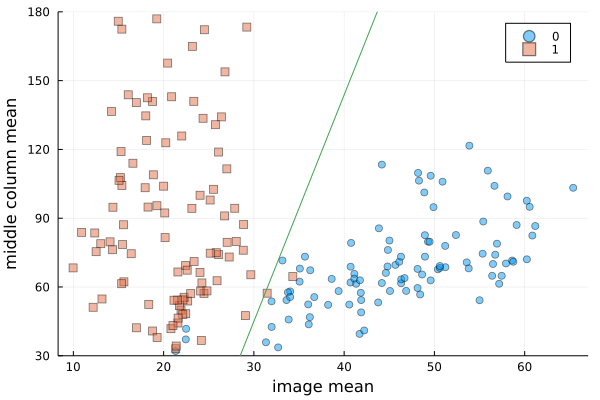

In [96]:
# Draw a line on the above plot based on x
a1 = LinRange(20,50,100)
a2 = -(x[3]/x[2] .+ x[1]/x[2]*a1)
plot!(ps, a1, a2, ylim=(30,180), label="")

In [97]:
savefig("task2_part2_scatter.png")

### Part 3

Now we are going to prepare to classify the *test* data
using out hand-crafted features
and our linear regression coefficient vector $x$.
If ```a``` denotes a vector with the 3 features for one test image,
then ```y = a' x``` is our predicted value
- if ```y``` is negative then the test image is probably a 0 digit
- if ```y``` is positive then the test image is probably a 1 digit.  

Compute a variable ```ytest0```
(a vector of length ```ntest```)
that is the predicted $y$ value
for each of the test "0" images.
This can be done with one line of code!
Likewise,
compute a variable ```ytest1```
for each of the test "1" images.

In [113]:
# TODO 
A0_test = data_to_features(test0)
A1_test = data_to_features(test1)
ytest0 = A0_test * x
ytest1 = A1_test * x

900×1 Matrix{Float64}:
 0.47274740187360764
 0.4415626953686591
 0.9997391285228536
 0.5821343470349915
 0.5639899712382205
 0.5161180521808749
 0.38587890176423634
 0.5031423735306004
 0.8121141636733894
 0.8444376254656425
 0.5611140983093761
 0.01612536242455409
 0.7562351181014867
 ⋮
 0.8559204965209142
 0.9272681675493049
 0.7212668670512247
 0.18934874509744137
 0.732571960930754
 0.5239190686287731
 0.4825733031539229
 0.4798414099632343
 1.1068767178398564
 0.7360630323845053
 0.3522574058241663
 1.2166839107787057

Next we make a historam plot of these predicted values to see how well we have separated the two classes.  Your histograms should look somewhat like the two overlapping distributions in this picture: 
https://en.wikipedia.org/wiki/Receiver_operating_characteristic#/media/File:ROC_curves.svg

Include your histogram in your report.

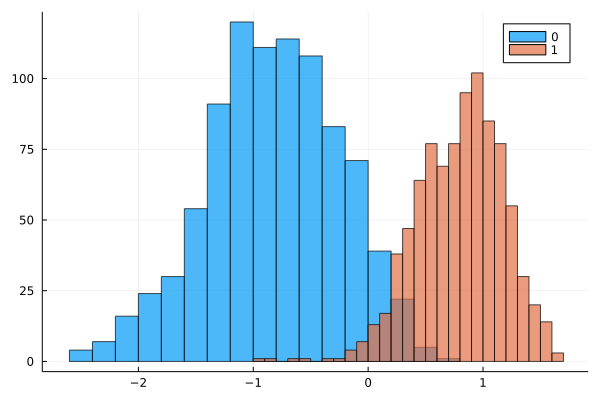

In [114]:
histogram(ytest0, alpha=0.7, label="0")
histogram!(ytest1, alpha=0.7, label="1")

In [115]:
savefig("task2_part3_hist.png")

Now, count the number of 0 digits that are classified correctly
using the classification rule $y < 0$ means 0 and $y > 0$ means 1.  
Calculate the *percentage* of correctly classified digits.  
Report your percentages in your report
and comment on how well (or poorly) it does.

Hint: To find a way to count the number of correctly classified training samples, look at chpt. 4 p. 69

In [117]:
count( i->(i<0),ytest0)c

833

In [118]:
# TODO 

correct0 = count( i->(i<0),ytest0)
correct1 = count( i->(i>0),ytest1)
display("Percent 0 correct = $(correct0 / ntest)")
display("Percent 1 correct = $(correct1 / ntest)")
display("Percent over all  training samples  = $((correct1 + correct0) / (2*ntest))")

"Percent 0 correct = 0.9255555555555556"

"Percent 1 correct = 0.9811111111111112"

"Percent over all  training samples  = 0.9533333333333334"

### Part 4
Find the digits that were misclassified.  
In your report, display an image of a few of these digits. 
Comment on why you think these digits were misclassified.

In [119]:
# Find the indexes of the misclassified digits
incorrect0 = findall(>=(0), ytest0);
incorrect1 = findall(<=(0), ytest1);

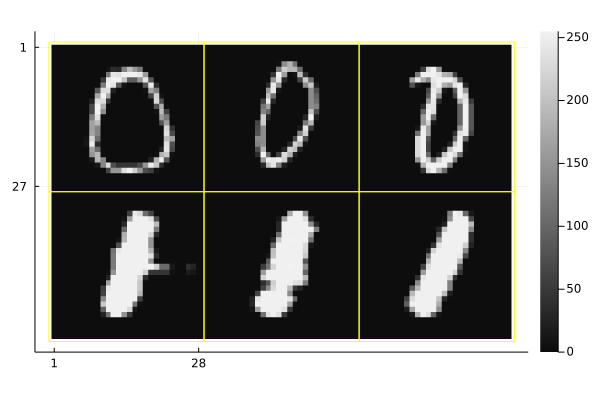

In [120]:
# Display some of the incorrectly classified digits
jim(cat(test0[:,:,incorrect0[1:3]], test1[:,:,incorrect1[1:3]], dims = 3))

In [121]:
savefig("task2_part4_misclassified_digits.png")

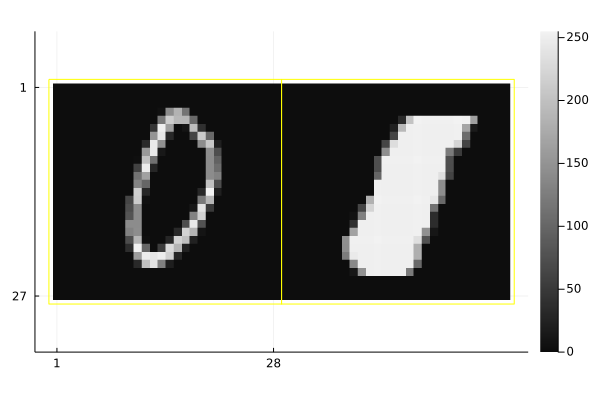

In [122]:
# Optional: show the 0 and 1 images that are the "worst" classified here
worst0 = argmax(ytest0)
worst1 = argmin(ytest1)
jim(cat(test0[:,:,worst0], test1[:,:,worst1], dims = 3))

## Part 5
We can regularize our solution through $\textbf{Tikonov Regularization}$. 
The objective function using Tikhonov Regularization is as follows: 

$$\mathbf{\hat{x}} = \arg\min_x \mathbf{ \| diag(y)Ax - 1\|_2^2 + \beta \|x\|_2^2 }$$

We can re-formulate this problem to look like the traditional least-squares problem by "stacking" 

$$\mathbf{\hat{x}} = \arg\min_x \mathbf{ \| \begin{bmatrix} \mathbf{ diag(y)A} \\ \sqrt{\beta} \mathbf{I} \end{bmatrix}x - \begin{bmatrix} \mathbf{1} \\ \mathbf{0} \end{bmatrix} \|_2^2 }$$

Here, we can re-define 

$$\mathbf{\tilde{A}} = \begin{bmatrix} \mathbf{ diag(y)A} \\ \sqrt{\beta} \mathbf{I} \end{bmatrix}$$

$$\mathbf{\tilde{y}} =  \begin{bmatrix} \mathbf{1} \\ \mathbf{0} \end{bmatrix}$$

$$\mathbf{\hat{x}} = \arg\min_x \mathbf{ \| \tilde{A}x - \tilde{y}\|_2^2}$$

Apply Tikhonov Regularization to solve the this new Least-Squares problem for Linear Regression


In [162]:
β = 10
Matrix{Float64}(I, 3, 3)
β_maxtrix = sqrt(β) * Matrix{Float64}(I, 1, 3)
typeof(Y*A)
display(size(β_maxtrix))
display(size(Y*A))


(1, 3)

(200, 3)

In [186]:
# TODO 

β = 10 #pre-defined regularization term 
β_maxtrix = sqrt(β) * Matrix{Float64}(I, 3, 3)

At = vcat(Y*A, β_maxtrix )
yy=  vcat(ones(200, 1), zeros(3,1))
# bb = ???
xx = pinv(At) * yy


@show round.(xx, digits=3)

round.(xx, digits = 3) = [-0.049; 0.01; 0.838]


3×1 Matrix{Float64}:
 -0.049
  0.01
  0.838

In [187]:
# Determine classification accuracy using Tikhonov Regularization 
ytest0 = data_to_features(test0) * xx
ytest1 = data_to_features(test1) * xx;

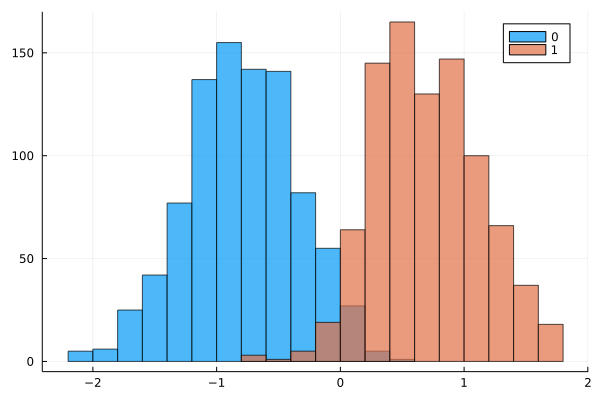

In [188]:
histogram(ytest0, alpha=0.7, label="0")
histogram!(ytest1, alpha=0.7, label="1")

#### correct0 = count(<(0), ytest0)
correct1 = count(>(0), ytest1)

display("Percent 0 correct = $(correct0 / ntest)")
display("Percent 1 correct = $(correct1 / ntest)")
display("Percent correct over all test samples: $((correct0 + correct1) / (2*ntest))" )


Here, we are tuning our parameters to maximize test accuracy. However, this is not what is done in practice. In practice, you would tune your parameters based on the accuracy in the training/validation set, and then deploy our classifier with our chosen $\beta$ on the test set. 


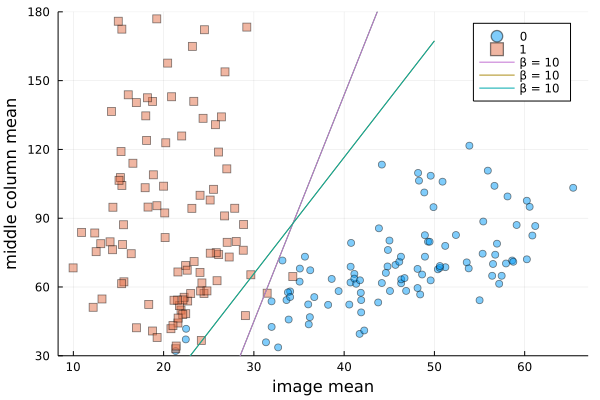

In [190]:
# Draw a line on the above plot based on x
a_t1 = LinRange(20,50,100)
a_t2 = -(xx[3]/xx[2] .+ xx[1]/xx[2]*a1)
plot!(ps, a_t1, a_t2, ylim=(30,180), label="β = $(β)")

In [179]:
# Find the indexes of the misclassified digits
incorrect0 = findall(>(0), ytest0);
incorrect1 = findall(<(0), ytest1);

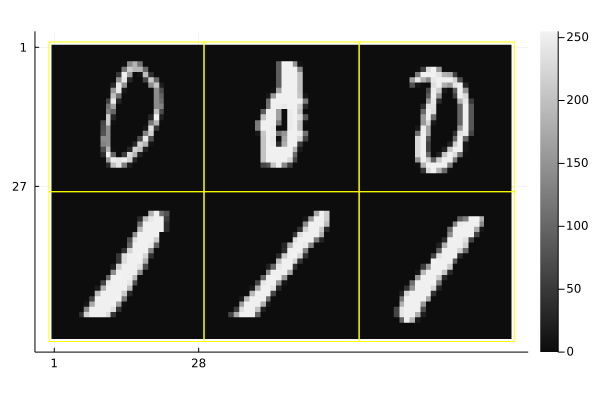

In [180]:
# Display some of the incorrectly classified digits
jim(cat(test0[:,:,incorrect0[1:3]], test1[:,:,incorrect1[1:3]], dims = 3))

Include the worst classified digits when using Tikhonov Regularization with a value of $\beta = 10$ in your report

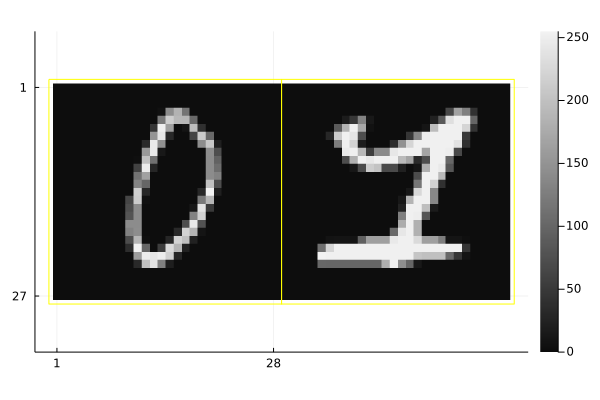

In [181]:
# Optional: show the 0 and 1 images that are the "worst" classified here
worst0 = argmax(ytest0)
worst1 = argmin(ytest1)
jim(cat(test0[:,:,worst0], test1[:,:,worst1], dims = 3))

### Optional Parts
- Try including your own additional hand-crafted feature(s)
to see if you can improve the classification accuracy.
- Try this approach for the harder problem 4 vs 9 instead of the easier 0 vs 1.  
- Extend this notebook to handle 3 digits (do not bother trying all 10).  
- These images are $28 \times 27$ and it is hard to visualize vectors in $\mathbf{R}^{756}$. Think about how to make a 2D picture that shows the test data as a colored scatter plot with a dividing line separating (hopefully) the two classes.
